# Fremskrivning af epidemikurven for COVID-19 i Danmark

**Dette dokument danner en eksponentiel fremskriver epidemikurven ud fra dagsaktuelle tal for smittede,
 indlagt og døde.**

*Koden til denne notebook findes på GitHub, se [github.com COVID-19-dk](https://github.com/covid-19-sim/covid-19-dk)*

## Metode
Vi anvender eksponentiel fremskrivning.

Det er en meget grovkornet metode, som kun kan bruges til kortsigtede fremskrivninger, da den ikke tager højde for
at epidemien over tid har færre og færre raske at ramme (dvs. at kurven begynder at bue nedad).

Den er dog relevant, da det er en fin måde at vise data på i starten af epidemien og få en idé om den aktuelle vækstrate.

## Datagrundlag

Data er indhentet fra Sundhedsstyrelsens hjemmeside for 
[COVID-19 tal og overvågning](https://www.sst.dk/da/corona/tal-og-overvaagning).

Læs mere om datasættet på https://github.com/covid-19-sim/covid-19.sst.dk

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.optimize

plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/covid-19-sim/covid-19.sst.dk/master/total-covid-19-dk.csv',
                 parse_dates=['Date'])

df.head(1000)

,Date,Tested,Total tested,Confirmed,Total confirmed,Hospitalised,ICU,ICU-vent,Deaths,Total deaths
0,2020-03-03,508.0,508.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN
1,2020-03-04,84.0,592.0,3.0,16.0,NaN,NaN,NaN,NaN,NaN
2,2020-03-05,93.0,685.0,10.0,26.0,NaN,NaN,NaN,NaN,NaN
3,2020-03-06,124.0,809.0,2.0,28.0,NaN,NaN,NaN,NaN,NaN
4,2020-03-07,103.0,912.0,9.0,37.0,NaN,NaN,NaN,NaN,NaN
5,2020-03-08,224.0,1136.0,48.0,85.0,NaN,NaN,NaN,NaN,NaN
6,2020-03-09,570.0,1706.0,210.0,295.0,NaN,NaN,NaN,NaN,NaN
7,2020-03-10,796.0,2502.0,256.0,551.0,NaN,NaN,NaN,NaN,NaN
8,2020-03-11,869.0,3371.0,207.0,758.0,NaN,NaN,NaN,1.0,1.0
9,2020-03-12,661.0,4032.0,44.0,802.0,19.0,3.0,NaN,0.0,1.0


In [3]:
# Kontroller at data har det forventede format
for c in ['Date', 'Total tested', 'Total confirmed', 'Hospitalised', 'ICU', 'ICU-vent', 'Deaths', 'Total deaths']:
    assert c in df.columns    

In [4]:
# Epidemistarten er den første dato 
EPIDEMI_START = pd.Timestamp("2020-03-03")

df['Day'] = df['Date'] - EPIDEMI_START
df['Day N'] = df['Day'].dt.days


## Faktiske indlæggelser og dødsfald
Datasættet ser således ud når vi tegner graferne med henholdsvis lineær og logaritmisk y-akse.
Husk at en ret linie på logaritmisk y-akse svarer til konstant procentuel daglig tilvækst.   

In [5]:
# Udvælg data vi interesserer os for
OVERSKRIFTER = {'Total confirmed': 'Testet positive',
                'Hospitalised': 'Indlagte', 
                'ICU': 'Intensiv', 
                'ICU-vent': 'Intensiv med respirator', 
                'Total deaths': 'Døde'}

kolonner = list(OVERSKRIFTER.keys())

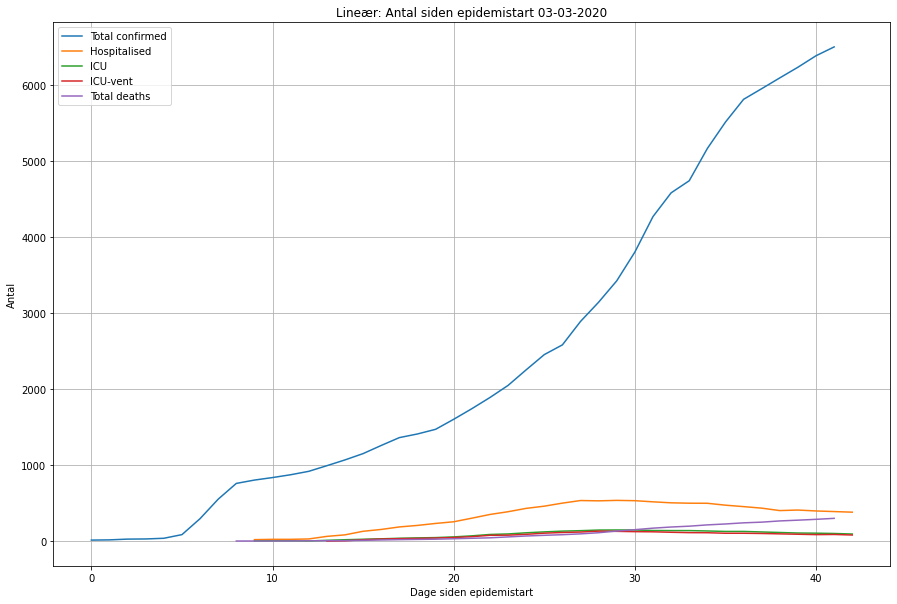

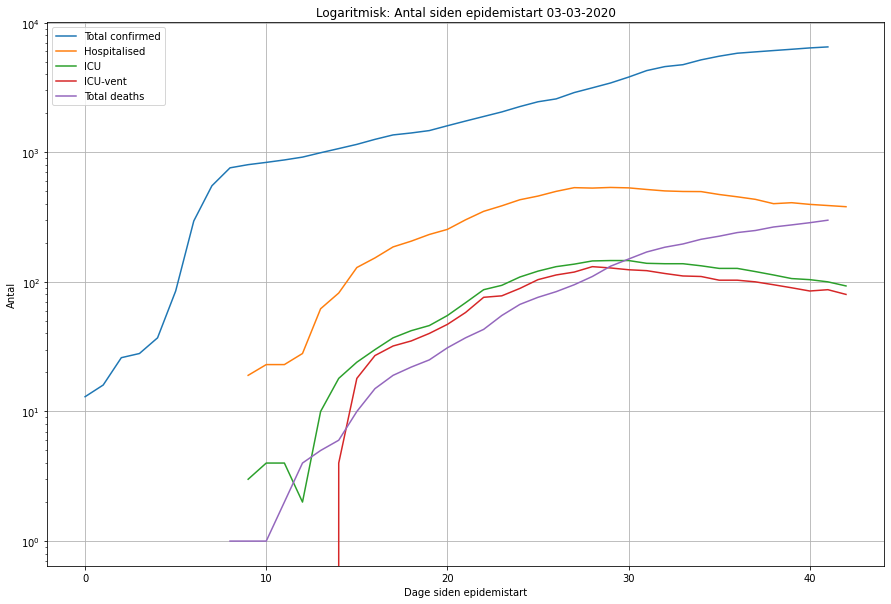

In [6]:
for is_log_plot, titel in [[False, "Lineær"], [True, "Logaritmisk"]]:
    ax = df.plot(x='Day N', y=kolonner, grid=True, logy=is_log_plot,
            title=f'{titel}: Antal siden epidemistart {EPIDEMI_START.date().strftime("%d-%m-%Y")}')
    plt.xlabel('Dage siden epidemistart')
    plt.ylabel('Antal')
    plt.show()

## Eksponentiel fremskrivning

Vi estimerer $a$ og $b$ en simpel eksponentialfunktion til dødsfaldskurven, 

$$\hat{y} = a e^{b x}$$ 

$x$ er dage siden epidemistart, $\hat{y}$ er det estimere antal døde. 

SciPy har en indbygget funktion til at dette, `curve_fit`:

In [7]:
# Hvis ikke vi har observationen, så drop rækken
data = df[['Day N'] + kolonner]

def exp_func(x, a, b):
    return a * np.exp(b * x)

def estimer_a_b(xs,ys):
    """Estimer a og b baseret på alle observationer"""
    popt, pcov = scipy.optimize.curve_fit(exp_func, xs, ys, bounds=([-100000, -100000],[100000, 100000]))
    a,b = popt
    return a,b    

Vi kan også beregne en rullende prognose baseret på kun de nyeste observationer. Dette giver os mulighed for at 
se tendensen.

In [8]:
TENDENS_DAGE = 7

def estimer_tendens(xs,ys):
    """Estimer a og b på bases af de seneste dages observationer (rullende prognose)"""
    popt, pcov = scipy.optimize.curve_fit(exp_func, xs[-TENDENS_DAGE-1:], ys[-TENDENS_DAGE-1:], bounds=([-100000, -100000],[100000, 100000]))
    a,b = popt
    return a,b    

In [9]:
# Estimer alle kolonnerne
estimater = {}

for k in kolonner:
    data_renset = data[['Day N', k]].dropna()
    x_data = data_renset['Day N']
    y_data = data_renset[k]
    a, b = estimer_a_b(x_data,y_data)
    a_tendens, b_tendens = estimer_tendens(x_data, y_data)
    overskrift = OVERSKRIFTER[k]
    print(f'{overskrift:30}: a         = {a}')
    print(f'{overskrift:30}: b         = {b}')
    print(f'{overskrift:30}: a_tendens = {a_tendens}')
    print(f'{overskrift:30}: b_tendens = {b_tendens}')
    print()
    estimater[k] = {'a': a, 'b': b, 'x_data': x_data, 'y_data': y_data, 
                    'a_tendens': a_tendens, 'b_tendens': b_tendens} 


Testet positive               : a         = 438.2627854878885
Testet positive               : b         = 0.06919843099859764
Testet positive               : a_tendens = 1936.5358209424057
Testet positive               : b_tendens = 0.029876469032883803

Indlagte                      : a         = 136.88667745992134
Indlagte                      : b         = 0.03333007910790302
Indlagte                      : a_tendens = 1377.4033508797086
Indlagte                      : b_tendens = -0.031141522238084245

Intensiv                      : a         = 31.962566991132107
Intensiv                      : b         = 0.03678664411970968
Intensiv                      : a_tendens = 642.7783739181268
Intensiv                      : b_tendens = -0.04570056439039029

Intensiv med respirator       : a         = 35.194290201166496
Intensiv med respirator       : b         = 0.02942456774829154
Intensiv med respirator       : a_tendens = 386.9026623063274
Intensiv med respirator       : b_tendens = 

Den daglige vækstrate er $${{\hat{y}_{t} - \hat{y}_{t-1}}\over{\hat{y}_{t-1}}} = e^b -1$$ hvor $t$ angiver dage siden epidemistart.

In [10]:
# Vis den daglige vækstrate
print('For hele epidimien')
for k in kolonner:
    daglig_vaekstrate = np.exp(estimater[k]['b']) -1
    print(f'{OVERSKRIFTER[k]:30}: Daglig vækst i antal: {daglig_vaekstrate:> 6.1%}')
print('')
print(f'For de sidste {TENDENS_DAGE} dage')
for k in kolonner:
    daglig_vaekstrate = np.exp(estimater[k]['b_tendens']) -1
    print(f'{OVERSKRIFTER[k]:30}: Daglig vækst i antal: {daglig_vaekstrate:> 6.1%}')

For hele epidimien
Testet positive               : Daglig vækst i antal:   7.2%
Indlagte                      : Daglig vækst i antal:   3.4%
Intensiv                      : Daglig vækst i antal:   3.7%
Intensiv med respirator       : Daglig vækst i antal:   3.0%
Døde                          : Daglig vækst i antal:   9.5%

For de sidste 7 dage
Testet positive               : Daglig vækst i antal:   3.0%
Indlagte                      : Daglig vækst i antal:  -3.1%
Intensiv                      : Daglig vækst i antal:  -4.5%
Intensiv med respirator       : Daglig vækst i antal:  -3.6%
Døde                          : Daglig vækst i antal:   4.9%


In [11]:
# Højeste dato med en faktisk observation, herefter følger prognosen
day_N_max_alle = int(np.max(data[['Day N']]))
date_max_alle = datetime.timedelta(days=day_N_max_alle) + EPIDEMI_START

FREMSKRIV_DAGE = 30
x_data_alle = np.arange(0, day_N_max_alle+FREMSKRIV_DAGE+1)
x_data_fremskrivning = x_data_alle[-FREMSKRIV_DAGE-1:]

Så er vi klar til at tegne grafer med data og prognoser:

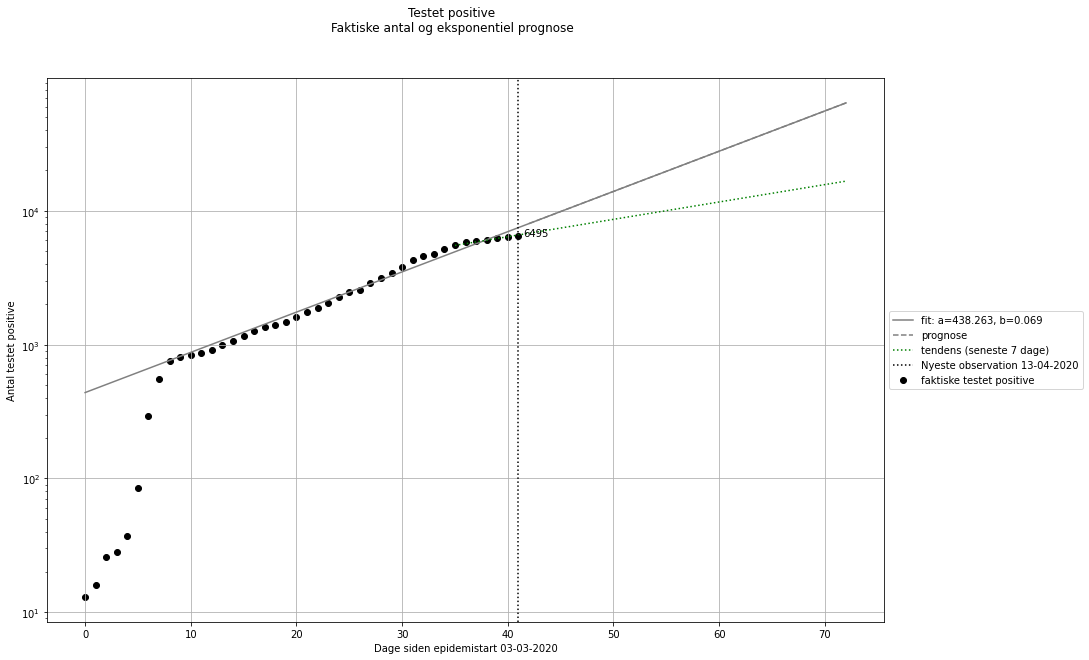

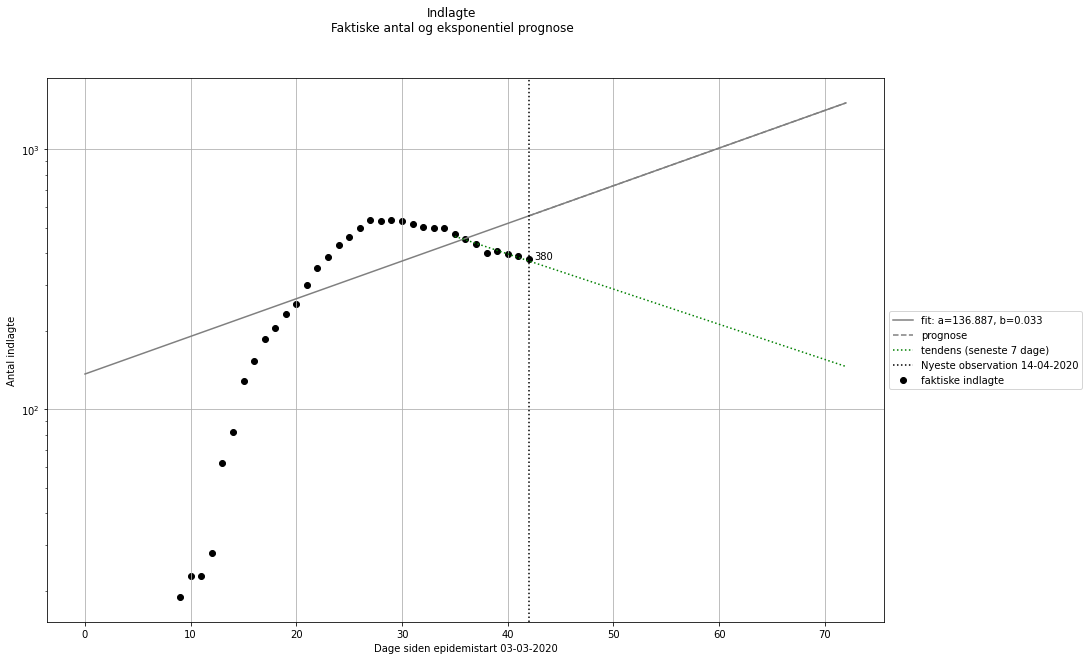

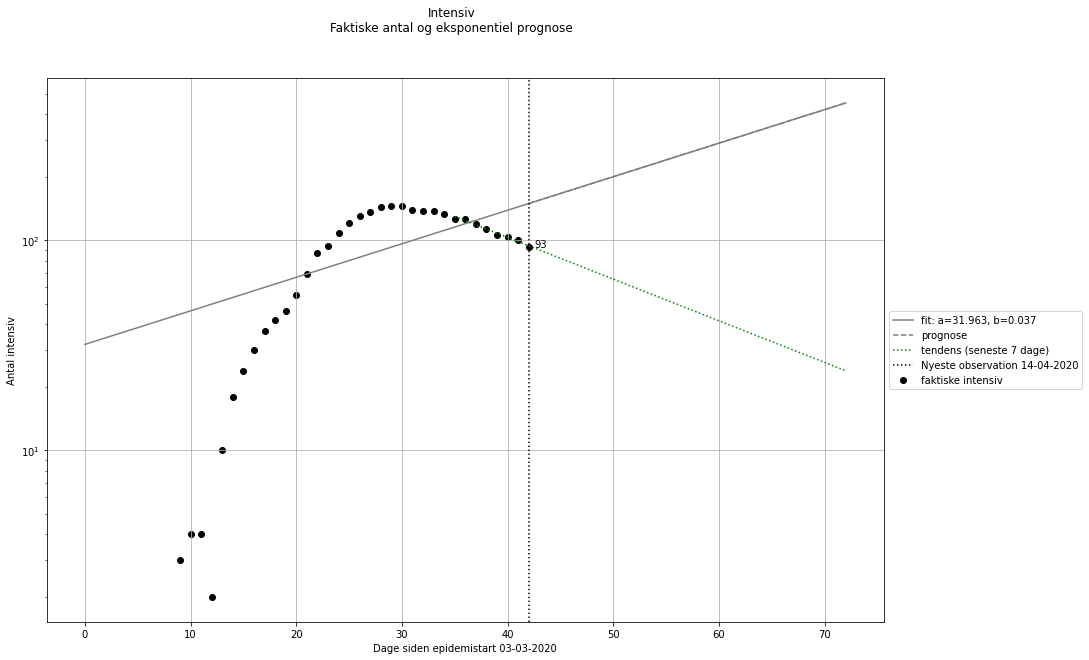

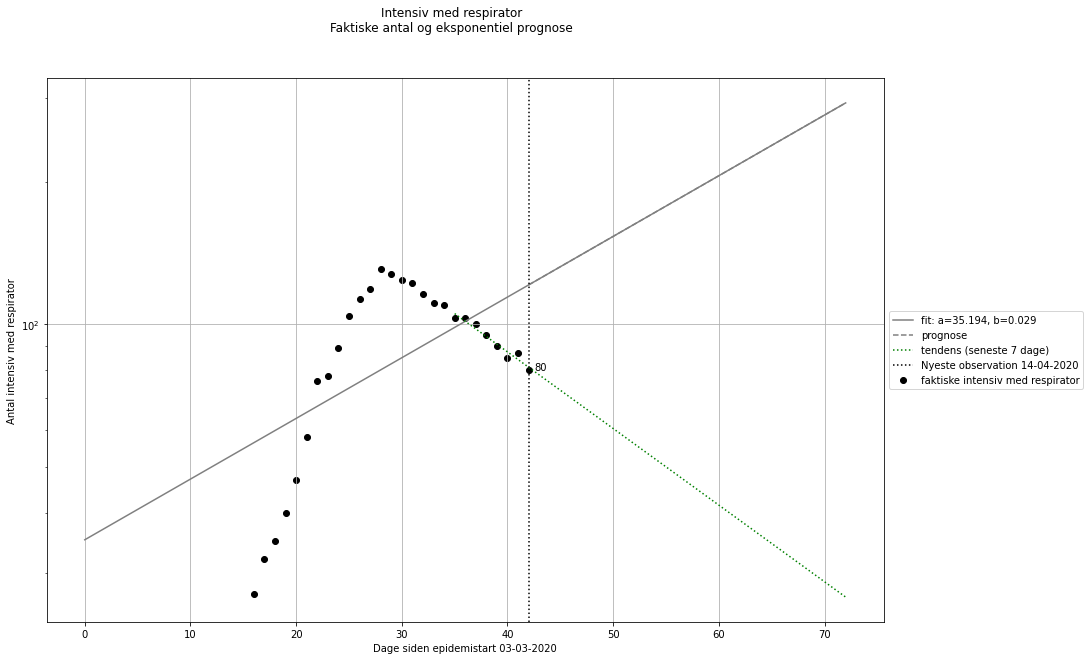

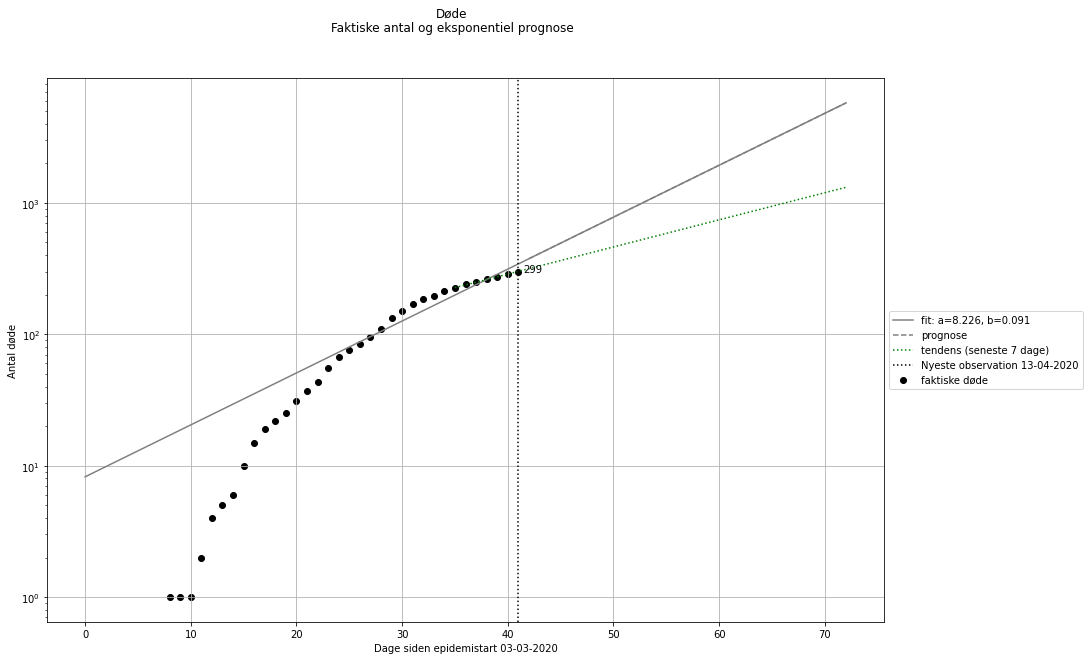

In [12]:
for k in kolonner:
    a = estimater[k]['a']
    b = estimater[k]['b']
    a_tendens = estimater[k]['a_tendens']
    b_tendens = estimater[k]['b_tendens']
    x_data = estimater[k]['x_data']
    y_data = estimater[k]['y_data']
    overskrift = OVERSKRIFTER[k] 

    day_N_max = int(np.max(x_data))
    date_max = datetime.timedelta(days=day_N_max) + EPIDEMI_START

    y_data_fremskrivning = exp_func(x_data_fremskrivning, a, b)

    x_data_tendens_fremskrivning = x_data_alle[-(1+TENDENS_DAGE+FREMSKRIV_DAGE):]
    y_data_tendens_fremskrivning = exp_func(x_data_tendens_fremskrivning, a_tendens, b_tendens)
    
    plt.plot(x_data_alle, exp_func(x_data_alle, a, b), c='grey', ls='-', label='fit: a=%5.3f, b=%5.3f' % (a,b))
    plt.plot(x_data_fremskrivning, y_data_fremskrivning, c='grey', ls='--', label='prognose')
    plt.scatter(x_data, y_data, c='black', label=f'faktiske {overskrift.lower()}')
    plt.plot(x_data_tendens_fremskrivning, y_data_tendens_fremskrivning, c='green', ls=':', label=f'tendens (seneste {TENDENS_DAGE} dage)')
    
    nyeste_xy = (x_data.to_list()[-1] + .5, y_data.to_list()[-1])
    plt.annotate(f'{int(nyeste_xy[1])}', nyeste_xy) 
    
    plt.xlabel(f'Dage siden epidemistart {EPIDEMI_START.strftime("%d-%m-%Y")}')
    plt.ylabel(f'Antal {overskrift.lower()}')
    plt.axvline(day_N_max, color='k', linestyle=':', 
                label=f'Nyeste observation {date_max.date().strftime("%d-%m-%Y")}')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.suptitle(f'{overskrift}\nFaktiske antal og eksponentiel prognose')
    plt.yscale('log')
    plt.grid()
    
    plt.show()